# Step 0: Load Packages and Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import os
from scipy.sparse import coo_matrix

ModuleNotFoundError: No module named 'matplotlib'

# Step 1: Data Loading and Preprocessing

In [3]:
# Read your dataset (replace 'marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv' with your dataset path)
train_data = pd.read_csv('marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv', sep='\t')
train_data.columns

Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 'Product Category', 'Product Brand', 'Product Name',
       'Product Price', 'Sku', 'Upc', 'Product Url', 'Market',
       'Product Description', 'Product Currency',
       'Product Available Inventory', 'Product Image Url',
       'Product Model Number', 'Product Tags', 'Product Contents',
       'Product Rating', 'Product Reviews Count', 'Bsr', 'Joining Key'],
      dtype='object')

In [5]:
train_data = train_data[['Uniq Id','Product Id', 'Product Rating', 'Product Reviews Count', 'Product Category', 'Product Brand', 'Product Name', 'Product Image Url', 'Product Description', 'Product Tags']]
train_data.head(3)

,Uniq Id,Product Id,Product Rating,Product Reviews Count,Product Category,Product Brand,Product Name,Product Image Url,Product Description,Product Tags
0,1705736792d82aa2f2d3caf1c07c53f4,2e17bf4acecdece67fc00f07ad62c910,NaN,NaN,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,NaN,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,95a9fe6f4810fcfc7ff244fd06784f11,076e5854a62dd283c253d6bae415af1f,NaN,NaN,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8d4d0330178d3ed181b15a4102b287f2,8a4fe5d9c7a6ed26cc44d785a454b124,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...


# Basic Operations

In [6]:
train_data['Product Tags']

0       OPI Infinite Shine, Nail Lacquer Nail Polish, ...
1       Nice 'n Easy Permanent Color, 111 Natural Medi...
2       Clairol Nice 'N Easy Permanent Color 7/106A Na...
3       Kokie Professional Matte Lipstick, Hot Berry, ...
4       Gillette TRAC II Plus Razor Blade Refills, Fit...
                              ...                        
4995    Garden Mint Room Spray (Double Strength), 4 ou...
4996    Garnier Nutrisse Nourishing Hair Color Creme (...
4997    Nail File Electric Drill, 6 in 1 Professional ...
4998    Creed Love In Black Hair And Body Wash 6.8oz/2...
4999                    Foundation, Wal-mart, Walmart.com
Name: Product Tags, Length: 5000, dtype: object

In [7]:
train_data.shape

(5000, 10)

In [8]:
train_data.isnull().sum()

Uniq Id                     0
Product Id                  0
Product Rating           2806
Product Reviews Count    1654
Product Category           10
Product Brand              13
Product Name                0
Product Image Url           0
Product Description      1127
Product Tags                0
dtype: int64

In [10]:
# Fill missing values in 'Product Rating' with a default value (e.g., 0)
train_data['Product Rating'].fillna(0, inplace=True)
# Fill missing values in 'Product Reviews Count' with a default value (e.g., 0)
train_data['Product Reviews Count'].fillna(0, inplace=True)
# Fill missing values in 'Product Category' with a default value (e.g., 'Unknown')
train_data['Product Category'].fillna('', inplace=True)
# Fill missing values in 'Product Brand' with a default value (e.g., 'Unknown')
train_data['Product Brand'].fillna('', inplace=True)
# Fill missing values in 'Product Description' with an empty string
train_data['Product Description'].fillna('', inplace=True)

C:\Users\abhis\AppData\Local\Temp\ipykernel_24948\3654264793.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Product Rating'].fillna(0, inplace=True)
C:\Users\abhis\AppData\Local\Temp\ipykernel_24948\3654264793.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

In [11]:
train_data.isnull().sum()

Uniq Id                  0
Product Id               0
Product Rating           0
Product Reviews Count    0
Product Category         0
Product Brand            0
Product Name             0
Product Image Url        0
Product Description      0
Product Tags             0
dtype: int64

In [12]:
train_data.duplicated().sum()

np.int64(0)

In [13]:
# make columns shorter
# Define the mapping of current column names to shorter names
column_name_mapping = {
    'Uniq Id': 'ID',
    'Product Id': 'ProdID',
    'Product Rating': 'Rating',
    'Product Reviews Count': 'ReviewCount',
    'Product Category': 'Category',
    'Product Brand': 'Brand',
    'Product Name': 'Name',
    'Product Image Url': 'ImageURL',
    'Product Description': 'Description',
    'Product Tags': 'Tags',
    'Product Contents': 'Contents'
}
# Rename the columns using the mapping
train_data.rename(columns=column_name_mapping, inplace=True)

In [14]:
train_data['ID'] = train_data['ID'].str.extract(r'(\d+)').astype(float)
train_data['ProdID'] = train_data['ProdID'].str.extract(r'(\d+)').astype(float)

# Step 2: EDA (Exploratory Data Analysis)

In [15]:
# Basic statistics
num_users = train_data['ID'].nunique()
num_items = train_data['ProdID'].nunique()
num_ratings = train_data['Rating'].nunique()
print(f"Number of unique users: {num_users}")
print(f"Number of unique items: {num_items}")
print(f"Number of unique ratings: {num_ratings}")

Number of unique users: 1721
Number of unique items: 1697
Number of unique ratings: 36


In [ ]:
# Pivot the DataFrame to create a heatmap
heatmap_data = train_data.pivot_table('ID', 'Rating')

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='coolwarm', cbar=True)
plt.title('Heatmap of User Ratings')
plt.xlabel('Ratings')
plt.ylabel('User ID')
plt.show()

NameError: name 'plt' is not defined

In [ ]:
# Pivot the DataFrame to create a heatmap
heatmap_data = train_data.pivot_table('ID', 'Rating')

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='coolwarm', cbar=True)
plt.title('Heatmap of User Ratings')
plt.xlabel('Ratings')
plt.ylabel('User ID')
plt.show()

In [2]:
# Distribution of interactions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
train_data['ID'].value_counts().hist(bins=10, edgecolor='k')
plt.xlabel('Interactions per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Interactions per User')

plt.subplot(1, 2, 2)
train_data['ProdID'].value_counts().hist(bins=10, edgecolor='k',color='green')
plt.xlabel('Interactions per Item')
plt.ylabel('Number of Items')
plt.title('Distribution of Interactions per Item')

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [3]:
# Most popular items
popular_items = train_data['ProdID'].value_counts().head(5)
popular_items.plot(kind='bar',color='red')
plt.title("Most Popular items")

NameError: name 'train_data' is not defined

<AxesSubplot:xlabel='Rating'>

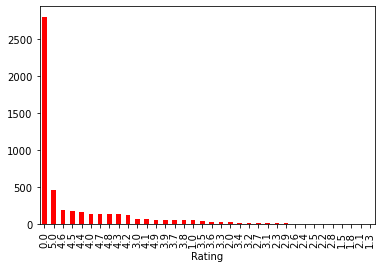

In [56]:
# most rated counts
train_data['Rating'].value_counts().plot(kind='bar',color='red')

# Step 3: Data Cleaning and Tags Creations

In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm")

def clean_and_extract_tags(text):
    doc = nlp(text.lower())
    tags = [token.text for token in doc if token.text.isalnum() and token.text not in STOP_WORDS]
    return ', '.join(tags)

columns_to_extract_tags_from = ['Category', 'Brand', 'Description']

for column in columns_to_extract_tags_from:
    train_data[column] = train_data[column].apply(clean_and_extract_tags)

In [ ]:
# Concatenate the cleaned tags from all relevant columns
train_data['Tags'] = train_data[columns_to_extract_tags_from].apply(lambda row: ', '.join(row), axis=1)

# Rating Base Recommendations System

In [12]:
average_ratings = train_data.groupby(['Name','ReviewCount','Brand','ImageURL'])['Rating'].mean().reset_index()

In [13]:
top_rated_items = average_ratings.sort_values(by='Rating', ascending=False)

rating_base_recommendation = top_rated_items.head(10)

In [14]:
rating_base_recommendation['Rating'] = rating_base_recommendation['Rating'].astype(int)
rating_base_recommendation['ReviewCount'] = rating_base_recommendation['ReviewCount'].astype(int)

C:\Users\naimat\AppData\Local\Temp\ipykernel_4284\565725879.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_base_recommendation['Rating'] = rating_base_recommendation['Rating'].astype(int)
C:\Users\naimat\AppData\Local\Temp\ipykernel_4284\565725879.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_base_recommendation['ReviewCount'] = rating_base_recommendation['ReviewCount'].astype(int)


In [15]:
print("Rating Base Recommendation System: (Trending Products)")
rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']] = rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']]
rating_base_recommendation

Rating Base Recommendation System: (Trending Products)


C:\Users\naimat\AppData\Local\Temp\ipykernel_4284\393183274.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']] = rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']]


,Name,ReviewCount,Brand,ImageURL,Rating
1686,"Electric Shaver, Triple Shaving Time Electric ...",4,Moosoo,https://i5.walmartimages.com/asr/e7dcd553-90df...,5
526,"Alaffia Body Lotion, Vanilla, 32 Oz",2,Alaffia,https://i5.walmartimages.com/asr/2988c323-cb6f...,5
2053,"Gold Bond Ultimate Ultimate Healing Lotion, Al...",2,Gold Bond,https://i5.walmartimages.com/asr/34b610e7-05db...,5
4716,"Versace Man Eau Fraiche Eau De Toilette Spray,...",24,Versace,https://i5.walmartimages.com/asr/edaaeed5-9da0...,5
2058,Goldwell StyleSign 1 Flat Marvel Straightening...,2,Goldwell,https://i5.walmartimages.com/asr/3bf90289-6980...,5
3842,"Red Devil 0322 Steel Wool # 00 Very Fine, 8 Pa...",1,Red Devil,https://i5.walmartimages.com/asr/60bfe5ba-774c...,5
510,"Air Wick Plug in Starter Kit, Warmer + 1 Refil...",1,Air Wick,https://i5.walmartimages.com/asr/0fac65b2-c6aa...,5
3841,Recovery Complex Anti-Frizz Shine Serum by Bai...,4,Bain de Terre,https://i5.walmartimages.com/asr/fcdb4d2e-3727...,5
2687,Long Aid Extra Dry Formula Curl Activator Gel ...,12,Long Aid,https://i5.walmartimages.com/asr/f7f29199-bfa5...,5
2062,"Good Sense 60-Day Air Care System, Citrus, 2 o...",1,Diversey,https://i5.walmartimages.com/asr/025a7068-7bb1...,5


# Content Base Recommendation system (User Preferences or Items similarities)

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])
cosine_similarities_content = cosine_similarity(tfidf_matrix_content,tfidf_matrix_content)

In [17]:
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'
item_index = train_data[train_data['Name']==item_name].index[0]

In [18]:
similar_items = list(enumerate(cosine_similarities_content[item_index]))

In [19]:
similar_items = sorted(similar_items, key=lambda x:x[1], reverse=True)
top_similar_items = similar_items[1:10]

recommended_items_indics = [x[0] for x in top_similar_items]

In [20]:
train_data.iloc[recommended_items_indics][['Name','ReviewCount','Brand']]

,Name,ReviewCount,Brand
4854,"OPI Infinite Shine Nail Polish, Dulce De Leche...",1.0,OPI
3052,"OPI Nail Lacquer Nail Polish, Hawaiian Orchid",1.0,OPI
4010,"OPI Nail Polish, Are We There Yet?, 0.5 Fl Oz",2.0,OPI
4752,"OPI Infinite Shine Nail Polish, Let Love Spark...",3.0,OPI
4356,"OPI Nail Lacquer Nail Polish, Go with the Lava...",1.0,OPI
3967,"OPI Infinite Shine Nail Polish, Mini Scotland ...",1.0,OPI
2952,"OPI Nail Lacquer Nail Polish, Miami Beet",0.0,OPI
4966,OPI Nail GelColor + Infinite Shine Polish -TAU...,0.0,OPI
3252,"OPI Nail Lacquer Nail Polish, Shorts Story",1.0,OPI


# Function To Recommend Products for Content Base

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def content_based_recommendations(train_data, item_name, top_n=10):
    # Check if the item name exists in the training data
    if item_name not in train_data['Name'].values:
        print(f"Item '{item_name}' not found in the training data.")
        return pd.DataFrame()

    # Create a TF-IDF vectorizer for item descriptions
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    # Apply TF-IDF vectorization to item descriptions
    tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])

    # Calculate cosine similarity between items based on descriptions
    cosine_similarities_content = cosine_similarity(tfidf_matrix_content, tfidf_matrix_content)

    # Find the index of the item
    item_index = train_data[train_data['Name'] == item_name].index[0]

    # Get the cosine similarity scores for the item
    similar_items = list(enumerate(cosine_similarities_content[item_index]))

    # Sort similar items by similarity score in descending order
    similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)

    # Get the top N most similar items (excluding the item itself)
    top_similar_items = similar_items[1:top_n+1]

    # Get the indices of the top similar items
    recommended_item_indices = [x[0] for x in top_similar_items]

    # Get the details of the top similar items
    recommended_items_details = train_data.iloc[recommended_item_indices][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    return recommended_items_details

In [22]:
# Example: Get content-based recommendations for a specific item
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating
4854,"OPI Infinite Shine Nail Polish, Dulce De Leche...",1.0,OPI,https://i5.walmartimages.com/asr/466527fe-9e5e...,5.0
3052,"OPI Nail Lacquer Nail Polish, Hawaiian Orchid",1.0,OPI,https://i5.walmartimages.com/asr/cef5a3ca-dfed...,4.0
4010,"OPI Nail Polish, Are We There Yet?, 0.5 Fl Oz",2.0,OPI,https://i5.walmartimages.com/asr/bb0c5e20-0ead...,3.0
4752,"OPI Infinite Shine Nail Polish, Let Love Spark...",3.0,OPI,https://i5.walmartimages.com/asr/7eef48ac-3a28...,4.0
4356,"OPI Nail Lacquer Nail Polish, Go with the Lava...",1.0,OPI,https://i5.walmartimages.com/asr/6cd23e3d-f3be...,5.0
3967,"OPI Infinite Shine Nail Polish, Mini Scotland ...",1.0,OPI,https://i5.walmartimages.com/asr/b673df9d-cc73...,0.0
2952,"OPI Nail Lacquer Nail Polish, Miami Beet",0.0,OPI,https://i5.walmartimages.com/asr/083f9170-da65...,0.0
4966,OPI Nail GelColor + Infinite Shine Polish -TAU...,0.0,OPI,https://i5.walmartimages.com/asr/a364a6d7-0cd1...,0.0


In [23]:
# Example: Get content-based recommendations for a specific item
item_name = 'Kokie Professional Matte Lipstick, Hot Berry, 0.14 fl oz'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating
546,"Kokie Professional Matte Lipstick, Kiss Me, 0....",0.0,Kokie Cosmetics,https://i5.walmartimages.com/asr/27dd82a2-2b9c...,0.0
3406,"Kokie Professional Matte Lipstick, Firecracker...",0.0,Kokie Cosmetics,https://i5.walmartimages.com/asr/8312221b-ed22...,0.0
2873,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,Kokie Cosmetics,https://i5.walmartimages.com/asr/31c99d9b-ea11...,3.4
4050,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,Kokie Cosmetics,https://i5.walmartimages.com/asr/fdd7498c-319f...,3.4
3023,Be Matte Lipstick - Pink,2.0,City Color,https://i5.walmartimages.com/asr/4425a13e-085f...,3.0
558,"Kokie Professional Nail Polish, Girls Night , ...",6.0,Kokie Cosmetics,https://i5.walmartimages.com/asr/a6f6da7a-cb11...,4.2
4920,"Kokie Professional Nail Polish, Jamacan Me Blu...",6.0,Kokie Cosmetics,https://i5.walmartimages.com/asr/16fc0e60-1c66...,4.2
3620,"Kokie Professional Skin Perfect HD Foundation,...",9.0,Kokie Cosmetics,https://i5.walmartimages.com/asr/2f8fcaa9-7db7...,0.0


# Collaborative Filtering (User Item Similarity)

In [24]:
user_item_matrix = train_data.pivot_table(index='ID', columns='ProdID', values='Rating',aggfunc='mean').fillna(0).astype(int)

In [25]:
user_similarity = cosine_similarity(user_item_matrix)

In [26]:
target_user_id = 4
target_user_index = user_item_matrix.index.get_loc(target_user_id)

In [27]:
user_similarities = user_similarity[target_user_index]

similar_user_indices = user_similarities.argsort()[::-1][1:]

In [28]:
recommend_items = []

for user_index in similar_user_indices:
    rated_by_similar_user = user_item_matrix.iloc[user_index]
    not_rated_by_target_user = (rated_by_similar_user==0) & (user_item_matrix.iloc[target_user_index]==0)
    
    recommend_items.extend(user_item_matrix.columns[not_rated_by_target_user][:10])

recommended_items_details = train_data[train_data['ProdID'].isin(recommend_items)][['Name','ReviewCount','Brand','ImageURL','Rating']]

In [30]:
recommended_items_details.head(10)

,Name,ReviewCount,Brand,ImageURL,Rating
15,Clairol Natural Instincts Demi-Permanent Hair ...,2935.0,Clairol,https://i5.walmartimages.com/asr/00a6e54a-e431...,3.7
33,"DenTek Kids Fun Flossers, Removes Food & Plaqu...",3.0,DenTek,https://i5.walmartimages.com/asr/de6e52eb-6e18...,0.0
61,"COVERGIRL Exhibitionist Cream Lipstick, 395 Da...",713.0,COVERGIRL,https://i5.walmartimages.com/asr/95076ec0-ffbd...,4.3
64,Neutrogena SkinClearing Oil-Free Liquid Founda...,741.0,Neutrogena,https://i5.walmartimages.com/asr/fd4d78d8-310a...,4.2
69,Design Essentials Natural Coconut & Monoi Curl...,1.0,Design Essentials,https://i5.walmartimages.com/asr/ff2dba1d-0c02...,5.0
78,"Paul Sebastian Fine Cologne Spray, Cologne for...",28.0,Paul Sebastian,https://i5.walmartimages.com/asr/03d08a07-18d7...,4.8
85,"BioAstin Hawaiian Astaxanthin, Vegan, 12mg, 75 Ct",3.0,Bioastin,https://i5.walmartimages.com/asr/6da9e238-b19e...,5.0
92,"Bytewise Organic Moringa Leaf Powder, 12 Oz",0.0,Bytewise,https://i5.walmartimages.com/asr/076f2b3f-fdc3...,0.0
94,Ag Hair Cosmetics Ultradynamics Extra-Firm Fin...,0.0,AG Hair,https://i5.walmartimages.com/asr/5d217d98-a385...,0.0
108,OPI Nail Dipping Powder Perfection Combo - Liq...,1.0,OPI,https://i5.walmartimages.com/asr/ef1607ee-5bdb...,3.0


# Function That Recommend Items

In [34]:
def collaborative_filtering_recommendations(train_data, target_user_id, top_n=10):
    # Create the user-item matrix
    user_item_matrix = train_data.pivot_table(index='ID', columns='ProdID', values='Rating', aggfunc='mean').fillna(0)

    # Calculate the user similarity matrix using cosine similarity
    user_similarity = cosine_similarity(user_item_matrix)

    # Find the index of the target user in the matrix
    target_user_index = user_item_matrix.index.get_loc(target_user_id)

    # Get the similarity scores for the target user
    user_similarities = user_similarity[target_user_index]

    # Sort the users by similarity in descending order (excluding the target user)
    similar_users_indices = user_similarities.argsort()[::-1][1:]

    # Generate recommendations based on similar users
    recommended_items = []

    for user_index in similar_users_indices:
        # Get items rated by the similar user but not by the target user
        rated_by_similar_user = user_item_matrix.iloc[user_index]
        not_rated_by_target_user = (rated_by_similar_user == 0) & (user_item_matrix.iloc[target_user_index] == 0)

        # Extract the item IDs of recommended items
        recommended_items.extend(user_item_matrix.columns[not_rated_by_target_user][:top_n])

    # Get the details of recommended items
    recommended_items_details = train_data[train_data['ProdID'].isin(recommended_items)][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    return recommended_items_details.head(10)

# Example usage
target_user_id = 4
top_n = 5
collaborative_filtering_rec = collaborative_filtering_recommendations(train_data, target_user_id)
print(f"Top {top_n} recommendations for User {target_user_id}:")
collaborative_filtering_rec

Top 5 recommendations for User 4:


,Name,ReviewCount,Brand,ImageURL,Rating
61,"COVERGIRL Exhibitionist Cream Lipstick, 395 Da...",713.0,COVERGIRL,https://i5.walmartimages.com/asr/95076ec0-ffbd...,4.3
85,"BioAstin Hawaiian Astaxanthin, Vegan, 12mg, 75 Ct",3.0,Bioastin,https://i5.walmartimages.com/asr/6da9e238-b19e...,5.0
86,LOreal Paris Feria Multi-Faceted Shimmering Pe...,2144.0,L'Oreal Paris,https://i5.walmartimages.com/asr/c229026a-2b75...,3.1
108,OPI Nail Dipping Powder Perfection Combo - Liq...,1.0,OPI,https://i5.walmartimages.com/asr/ef1607ee-5bdb...,3.0
144,Covidien Curity Maternity Pad Heavy 4.33&quot ...,0.0,Covidien,https://i5.walmartimages.com/asr/e4e38217-ed43...,0.0
155,"Crest 3D White Brilliance Mouthwash, Alcohol F...",63.0,Crest,https://i5.walmartimages.com/asr/1fcc5525-9ae3...,0.0
174,COVERGIRL Outlast All-Day Moisturizing Lip Col...,36.0,COVERGIRL,https://i5.walmartimages.com/asr/4479896f-c6c4...,0.0
193,"Revlon ColorStay Skinny Liquid Liner, 304 Gree...",70.0,Revlon,https://i5.walmartimages.com/asr/aa3b20a6-3d6d...,4.5
212,"Comvita Certified UMF 20+ Manuka Honey, Raw & ...",0.0,Comvita,https://i5.walmartimages.com/asr/3cdc1498-a2ac...,0.0
241,"Ahava Mens Mineral Hand Cream, 3.4 Oz",0.0,Ahava,https://i5.walmartimages.com/asr/f74e4bb7-47d3...,0.0


# Hybrid Recommendations

In [39]:
# Hybrid Recommendations (Combine Content-Based and Collaborative Filtering)
def hybrid_recommendations(train_data,target_user_id, item_name, top_n=10):
    # Get content-based recommendations
    content_based_rec = content_based_recommendations(train_data,item_name, top_n)

    # Get collaborative filtering recommendations
    collaborative_filtering_rec = collaborative_filtering_recommendations(train_data,target_user_id, top_n)
    
    # Merge and deduplicate the recommendations
    hybrid_rec = pd.concat([content_based_rec, collaborative_filtering_rec]).drop_duplicates()
    
    return hybrid_rec.head(10)

In [40]:
# Example usage: Get hybrid recommendations for a specific user and item
target_user_id = 4 # Change this to the user_id you want recommendations for
item_name = "OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11"  # Change this to the item name
hybrid_rec = hybrid_recommendations(train_data,target_user_id, item_name, top_n=10)

print(f"Top 10 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec

Top 10 Hybrid Recommendations for User 4 and Item 'OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11':


,Name,ReviewCount,Brand,ImageURL,Rating
1215,OPI Nail Lacquer Polish .5oz/15mL - Put A Coat...,0.0,OPI,https://i5.walmartimages.com/asr/b51a716d-565c...,0.0
545,OPI Nail Lacquer Polish .5oz/15mL - Sweet Hear...,0.0,OPI,https://i5.walmartimages.com/asr/136eb3a3-1668...,0.0
3852,OPI Nail Lacquer Polish .5oz/15mL - A-taupe th...,1.0,OPI,https://i5.walmartimages.com/asr/4b895a60-06c2...,0.0
1594,Nail Lacquer - # NL E74 Youre Such a BudaPest ...,5.0,OPI,https://i5.walmartimages.com/asr/bb6e42b8-35ee...,5.0
4645,OPI Nail Lacquer Polish .5oz/15mL - Champagne ...,0.0,OPI,https://i5.walmartimages.com/asr/5f4ec827-6edc...,0.0
4109,OPI Nail Lacquer Polish .5oz/15mL - Girls Love...,0.0,OPI,https://i5.walmartimages.com/asr/6d70f6db-0442...,0.0
4310,OPI Nail Lacquer Polish .5oz/15mL - So Many Cl...,0.0,OPI,https://i5.walmartimages.com/asr/b24090e9-9cf9...,0.0
3719,OPI Nail Lacquer Polish .5oz/15mL - Ski Slope ...,0.0,OPI,https://i5.walmartimages.com/asr/8466cc9b-40da...,0.0
4010,"OPI Nail Polish, Are We There Yet?, 0.5 Fl Oz",2.0,OPI,https://i5.walmartimages.com/asr/bb0c5e20-0ead...,3.0
3052,"OPI Nail Lacquer Nail Polish, Hawaiian Orchid",1.0,OPI,https://i5.walmartimages.com/asr/cef5a3ca-dfed...,4.0


In [43]:
# Example usage: Get hybrid recommendations for a specific user and item
target_user_id = 10 # Change this to the user_id you want recommendations for
item_name = 'Black Radiance Perfect Tone Matte Lip Crème, Succulent Plum'

hybrid_rec = hybrid_recommendations(train_data,target_user_id, item_name, top_n=10)

print(f"Top 10 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec

Top 10 Hybrid Recommendations for User 10 and Item 'Black Radiance Perfect Tone Matte Lip Crème, Succulent Plum':


,Name,ReviewCount,Brand,ImageURL,Rating
896,"Black Radiance Perfect Tone Lip Color, Vintage...",78.0,Black Radiance,https://i5.walmartimages.com/asr/485f26b4-a19a...,4.7
2496,"Black Radiance Perfect Tone Lip Color, Hollywo...",18.0,Black Radiance,https://i5.walmartimages.com/asr/fe3da48f-5142...,4.3
2136,"Black Radiance Brilliant Effects Lip Gloss, Bl...",95.0,Black Radiance,https://i5.walmartimages.com/asr/f6784519-2c86...,4.4
3140,Laura Mercier Tone Perfecting Eye Gel Crème 0....,11.0,Laura Mercier,https://i5.walmartimages.com/asr/9cd9aea3-5ac3...,3.7
398,"IMAN Skin Tone Evener BB Crème, Light Sand",19.0,IMAN Cosmetics,https://i5.walmartimages.com/asr/b387123b-700d...,3.9
3885,Two-Tone Comfort Yoga Mat,0.0,EDX,https://i5.walmartimages.com/asr/75ebb9e7-07eb...,0.0
4589,"Revlon ColorStay Longwear Lip Liner, 665 Plum,...",1678.0,Revlon,https://i5.walmartimages.com/asr/075c59a0-3a35...,0.0
725,"LOreal Paris Colour Riche Lip Liner, Lasting P...",85.0,L'Oreal Paris,https://i5.walmartimages.com/asr/194b6bcc-6cd6...,4.4
680,Revlon Revlon Super Lustrous Lipstick with Vit...,2031.0,Revlon,https://i5.walmartimages.com/asr/f21188e6-b3ef...,4.4
1559,"LOreal Paris Colour Riche Matte Lip Liner, Mat...",495.0,L'Oreal Paris,https://i5.walmartimages.com/asr/baf97085-7231...,4.4
